# Backtesting Analysis and Summary Performance

## Key Activities:
1.  Use the custom backtesting engine in src/backtesting. This engine will take the daily factor scores, form a long/short portfolio (long bottom decile, short top decile), and calculate the strategy's daily returns.
2.  Compute key performance metrics: Sharpe ratio, Calmar ratio, max drawdown, turnover, and alpha. Use scipy.stats for significance testing of the results.
3.  Create a final Summary of the results

In [1]:
# Import required libraries for backtesting analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import sys
import os
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from datetime import datetime

# Add project root to path
project_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.append(project_root)

from src.backtester.engine import Backtester
from src.factor_lib.momentum import MomentumBacktester, apply_momentum_strategy

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✓ Libraries imported successfully")
print(f"Python path includes: {project_root}")

✓ Libraries imported successfully
Python path includes: /workspaces/-Cross-Sectional-Equity-Momentum-Reversal-Factor


In [2]:
# Activity 1: Use Custom Backtesting Engine for Long/Short Portfolio

print("Activity 1: Building Long/Short Momentum Reversal Portfolio")
print("="*60)

# Enhanced Momentum Backtester for Long/Short Strategy
class LongShortMomentumBacktester:
    def __init__(self, data_dict, initial_balance=100000, rebalance_freq=20):
        """
        Long/Short momentum reversal backtester
        Args:
            data_dict: Dictionary of stock data {ticker: DataFrame}
            initial_balance: Starting capital
            rebalance_freq: How often to rebalance (trading days)
        """
        self.data_dict = data_dict
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.rebalance_freq = rebalance_freq
        self.positions = {}  # Current positions
        self.portfolio_value = []
        self.trades = []
        self.returns = []
        
    def get_cross_sectional_signals(self, date, lookback_window=90):
        """Get signals based on cross-sectional momentum ranking"""
        daily_momentum = {}
        
        for ticker, df in self.data_dict.items():
            if date in df.index:
                # Calculate momentum for this date
                stock_data = df.loc[:date]
                if len(stock_data) >= lookback_window:
                    momentum = stock_data['Close'].iloc[-1] / stock_data['Close'].iloc[-lookback_window] - 1
                    daily_momentum[ticker] = {
                        'momentum': momentum,
                        'price': stock_data['Close'].iloc[-1]
                    }
        
        # Rank stocks by momentum
        if len(daily_momentum) >= 4:  # Need minimum stocks
            sorted_stocks = sorted(daily_momentum.items(), key=lambda x: x[1]['momentum'])
            
            # Bottom decile (low momentum) = Long positions
            # Top decile (high momentum) = Short positions
            n_stocks = len(sorted_stocks)
            decile_size = max(1, n_stocks // 10)
            
            long_stocks = sorted_stocks[:decile_size]  # Lowest momentum
            short_stocks = sorted_stocks[-decile_size:]  # Highest momentum
            
            signals = {}
            
            # Long signals (reversal expectation)
            for ticker, data in long_stocks:
                signals[ticker] = {'signal': 1, 'price': data['price'], 'momentum': data['momentum']}
            
            # Short signals  
            for ticker, data in short_stocks:
                signals[ticker] = {'signal': -1, 'price': data['price'], 'momentum': data['momentum']}
                
            return signals
        
        return {}
    
    def rebalance_portfolio(self, date, signals):
        """Rebalance the portfolio based on signals"""
        # Close all current positions
        portfolio_value = 0
        for ticker, position in self.positions.items():
            if ticker in self.data_dict and date in self.data_dict[ticker].index:
                current_price = self.data_dict[ticker].loc[date, 'Close']
                position_value = position['shares'] * current_price * position['direction']
                portfolio_value += position_value
                
                # Record trade
                self.trades.append({
                    'date': date,
                    'ticker': ticker,
                    'action': 'CLOSE',
                    'shares': position['shares'],
                    'price': current_price,
                    'direction': position['direction']
                })
        
        # Update balance with closed positions
        self.balance += portfolio_value
        self.positions = {}
        
        # Open new positions
        if signals and len(signals) > 0:
            position_size = self.balance / (2 * len(signals))  # Split between long and short
            
            for ticker, signal_data in signals.items():
                if ticker in self.data_dict and date in self.data_dict[ticker].index:
                    price = signal_data['price']
                    signal = signal_data['signal']
                    
                    shares = position_size / price
                    position_value = shares * price
                    
                    # Long position (signal = 1)
                    if signal == 1:
                        self.balance -= position_value
                        self.positions[ticker] = {
                            'shares': shares,
                            'entry_price': price,
                            'direction': 1
                        }
                        self.trades.append({
                            'date': date,
                            'ticker': ticker,
                            'action': 'BUY',
                            'shares': shares,
                            'price': price,
                            'direction': 1
                        })
                    
                    # Short position (signal = -1)
                    elif signal == -1:
                        self.balance += position_value  # Receive cash from short
                        self.positions[ticker] = {
                            'shares': shares,
                            'entry_price': price,
                            'direction': -1
                        }
                        self.trades.append({
                            'date': date,
                            'ticker': ticker,
                            'action': 'SELL_SHORT',
                            'shares': shares,
                            'price': price,
                            'direction': -1
                        })
    
    def calculate_portfolio_value(self, date):
        """Calculate current portfolio value"""
        current_positions_value = 0
        
        for ticker, position in self.positions.items():
            if ticker in self.data_dict and date in self.data_dict[ticker].index:
                current_price = self.data_dict[ticker].loc[date, 'Close']
                position_pnl = (current_price - position['entry_price']) * position['shares'] * position['direction']
                current_positions_value += position_pnl
        
        return self.balance + current_positions_value
    
    def run_backtest(self):
        """Run the complete backtest"""
        # Get all unique dates
        all_dates = set()
        for df in self.data_dict.values():
            all_dates.update(df.index)
        
        all_dates = sorted(list(all_dates))
        
        print(f"Running backtest from {all_dates[0]} to {all_dates[-1]}")
        print(f"Total trading days: {len(all_dates)}")
        
        rebalance_counter = 0
        
        for i, date in enumerate(all_dates):
            # Rebalance check
            if rebalance_counter % self.rebalance_freq == 0:
                signals = self.get_cross_sectional_signals(date)
                if signals:
                    self.rebalance_portfolio(date, signals)
                    print(f"Rebalanced on {date}: {len(signals)} positions")
            
            # Calculate daily portfolio value
            portfolio_val = self.calculate_portfolio_value(date)
            self.portfolio_value.append({
                'date': date,
                'value': portfolio_val,
                'cash': self.balance,
                'positions_count': len(self.positions)
            })
            
            # Calculate daily returns
            if i > 0:
                prev_val = self.portfolio_value[i-1]['value']
                daily_return = (portfolio_val - prev_val) / prev_val
                self.returns.append({
                    'date': date,
                    'return': daily_return,
                    'cumulative_return': (portfolio_val / self.initial_balance) - 1
                })
            
            rebalance_counter += 1
        
        return pd.DataFrame(self.portfolio_value), pd.DataFrame(self.returns)

# Load data for backtesting
print("\nLoading data for backtesting...")
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'JPM', 'JNJ', 'V', 'WMT', 'PG', 'UNH', 'DIS', 'MA']
start_date = "2020-01-01"
end_date = "2023-01-01"

backtest_data = {}
for ticker in tickers:
    try:
        df = yf.download(ticker, start=start_date, end=end_date, progress=False)
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = [col[0] for col in df.columns]
        
        # Ensure we have clean data
        df = df.dropna()
        if len(df) > 200:  # Minimum data requirement
            backtest_data[ticker] = df
            print(f"✓ {ticker}: {len(df)} days")
    except Exception as e:
        print(f"✗ Failed to load {ticker}: {e}")

print(f"\nLoaded {len(backtest_data)} stocks for backtesting")

# Initialize and run backtest
backtester = LongShortMomentumBacktester(backtest_data, initial_balance=100000, rebalance_freq=21)  # Monthly rebalancing
portfolio_df, returns_df = backtester.run_backtest()

print(f"\nBacktest completed!")
print(f"Total trades executed: {len(backtester.trades)}")
print(f"Final portfolio value: ${portfolio_df['value'].iloc[-1]:,.2f}")
print(f"Total return: {((portfolio_df['value'].iloc[-1] / backtester.initial_balance) - 1) * 100:.2f}%")

Activity 1: Building Long/Short Momentum Reversal Portfolio

Loading data for backtesting...
✓ AAPL: 756 days
✓ MSFT: 756 days
✓ AAPL: 756 days
✓ MSFT: 756 days
✓ GOOGL: 756 days
✓ AMZN: 756 days
✓ GOOGL: 756 days
✓ AMZN: 756 days
✓ TSLA: 756 days
✓ META: 756 days
✓ TSLA: 756 days
✓ META: 756 days
✓ NVDA: 756 days
✓ JPM: 756 days
✓ NVDA: 756 days
✓ JPM: 756 days
✓ JNJ: 756 days
✓ V: 756 days
✓ JNJ: 756 days
✓ V: 756 days
✓ WMT: 756 days
✓ WMT: 756 days
✓ PG: 756 days
✓ PG: 756 days


Failed to get ticker 'UNH' reason: Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


✓ UNH: 756 days
✓ DIS: 756 days
✓ DIS: 756 days
✓ MA: 756 days

Loaded 15 stocks for backtesting
Running backtest from 2020-01-02 00:00:00 to 2022-12-30 00:00:00
Total trading days: 756
Rebalanced on 2020-06-03 00:00:00: 2 positions
Rebalanced on 2020-07-02 00:00:00: 2 positions
Rebalanced on 2020-08-03 00:00:00: 2 positions
Rebalanced on 2020-09-01 00:00:00: 2 positions
Rebalanced on 2020-10-01 00:00:00: 2 positions
Rebalanced on 2020-10-30 00:00:00: 2 positions
Rebalanced on 2020-12-01 00:00:00: 2 positions
Rebalanced on 2020-12-31 00:00:00: 2 positions
Rebalanced on 2021-02-02 00:00:00: 2 positions
Rebalanced on 2021-03-04 00:00:00: 2 positions
Rebalanced on 2021-04-05 00:00:00: 2 positions
Rebalanced on 2021-05-04 00:00:00: 2 positions
Rebalanced on 2021-06-03 00:00:00: 2 positions
Rebalanced on 2021-07-02 00:00:00: 2 positions
Rebalanced on 2021-08-03 00:00:00: 2 positions
Rebalanced on 2021-09-01 00:00:00: 2 positions
Rebalanced on 2021-10-01 00:00:00: 2 positions
Rebalanced on 2

In [3]:
# Activity 2: Compute Key Performance Metrics

print("\nActivity 2: Performance Metrics Analysis")
print("="*50)

def calculate_performance_metrics(returns_df, portfolio_df, risk_free_rate=0.02):
    """Calculate comprehensive performance metrics"""
    
    if len(returns_df) == 0:
        return {}
    
    # Basic returns statistics
    daily_returns = returns_df['return'].values
    annual_return = np.mean(daily_returns) * 252
    annual_volatility = np.std(daily_returns) * np.sqrt(252)
    
    # Sharpe Ratio
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility if annual_volatility != 0 else 0
    
    # Maximum Drawdown
    cumulative_returns = (1 + returns_df['return']).cumprod()
    rolling_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    # Calmar Ratio
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Win Rate
    win_rate = (daily_returns > 0).sum() / len(daily_returns)
    
    # Value at Risk (95%)
    var_95 = np.percentile(daily_returns, 5)
    
    # Sortino Ratio (downside deviation)
    downside_returns = daily_returns[daily_returns < 0]
    downside_volatility = np.std(downside_returns) * np.sqrt(252) if len(downside_returns) > 0 else 0
    sortino_ratio = (annual_return - risk_free_rate) / downside_volatility if downside_volatility != 0 else 0
    
    # Calculate turnover (approximate)
    total_trades = len(backtester.trades)
    trading_days = len(returns_df)
    avg_position_count = portfolio_df['positions_count'].mean()
    turnover = (total_trades / 2) / (trading_days / 252) / avg_position_count if avg_position_count > 0 else 0
    
    # Statistical significance of returns
    t_stat, p_value = stats.ttest_1samp(daily_returns, 0)
    
    return {
        'Annual Return': annual_return,
        'Annual Volatility': annual_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Calmar Ratio': calmar_ratio,
        'Maximum Drawdown': max_drawdown,
        'Win Rate': win_rate,
        'VaR (95%)': var_95,
        'Total Return': (portfolio_df['value'].iloc[-1] / backtester.initial_balance) - 1,
        'Turnover': turnover,
        'T-Statistic': t_stat,
        'P-Value': p_value,
        'Best Day': daily_returns.max(),
        'Worst Day': daily_returns.min(),
        'Avg Daily Return': np.mean(daily_returns)
    }

# Calculate metrics
metrics = calculate_performance_metrics(returns_df, portfolio_df)

# Display results
print("PERFORMANCE METRICS SUMMARY")
print("="*50)
for metric, value in metrics.items():
    if metric in ['Annual Return', 'Annual Volatility', 'Total Return', 'Maximum Drawdown', 'Win Rate', 'VaR (95%)', 'Best Day', 'Worst Day', 'Avg Daily Return']:
        print(f"{metric:<20}: {value:>10.2%}")
    elif metric in ['Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio', 'Turnover', 'T-Statistic']:
        print(f"{metric:<20}: {value:>10.2f}")
    elif metric == 'P-Value':
        print(f"{metric:<20}: {value:>10.4f}")

# Benchmark comparison (SPY)
print(f"\n{'='*50}")
print("BENCHMARK COMPARISON")
print("="*50)

try:
    # Download SPY data for comparison
    spy_data = yf.download("SPY", start=start_date, end=end_date, progress=False)
    if isinstance(spy_data.columns, pd.MultiIndex):
        spy_data.columns = [col[0] for col in spy_data.columns]
    
    spy_returns = spy_data['Close'].pct_change().dropna()
    spy_annual_return = spy_returns.mean() * 252
    spy_annual_vol = spy_returns.std() * np.sqrt(252)
    spy_sharpe = (spy_annual_return - 0.02) / spy_annual_vol
    spy_total_return = (spy_data['Close'].iloc[-1] / spy_data['Close'].iloc[0]) - 1
    
    print(f"Strategy Annual Return  : {metrics['Annual Return']:>10.2%}")
    print(f"SPY Annual Return       : {spy_annual_return:>10.2%}")
    print(f"Excess Return           : {metrics['Annual Return'] - spy_annual_return:>10.2%}")
    print(f"")
    print(f"Strategy Sharpe Ratio   : {metrics['Sharpe Ratio']:>10.2f}")
    print(f"SPY Sharpe Ratio        : {spy_sharpe:>10.2f}")
    print(f"")
    print(f"Strategy Total Return   : {metrics['Total Return']:>10.2%}")
    print(f"SPY Total Return        : {spy_total_return:>10.2%}")
    
    # Alpha calculation
    alpha = metrics['Annual Return'] - spy_annual_return
    print(f"Strategy Alpha          : {alpha:>10.2%}")
    
except Exception as e:
    print(f"Could not load benchmark data: {e}")

# Statistical significance
print(f"\n{'='*50}")
print("STATISTICAL SIGNIFICANCE")
print("="*50)
print(f"T-Statistic             : {metrics['T-Statistic']:>10.2f}")
print(f"P-Value                 : {metrics['P-Value']:>10.4f}")
if metrics['P-Value'] < 0.05:
    print("✓ STATISTICALLY SIGNIFICANT: Returns are significantly different from zero")
else:
    print("✗ NOT SIGNIFICANT: Returns are not statistically significant")


Activity 2: Performance Metrics Analysis
PERFORMANCE METRICS SUMMARY
Annual Return       :    -10.51%
Annual Volatility   :     15.11%
Sharpe Ratio        :      -0.83
Sortino Ratio       :      -1.00
Calmar Ratio        :      -0.27
Maximum Drawdown    :    -39.22%
Win Rate            :     44.11%
VaR (95%)           :     -1.61%
Total Return        :    -29.49%
Turnover            :      11.82
T-Statistic         :      -1.20
P-Value             :     0.2293
Best Day            :      4.31%
Worst Day           :     -5.98%
Avg Daily Return    :     -0.04%

BENCHMARK COMPARISON
Strategy Annual Return  :    -10.51%
SPY Annual Return       :     10.18%
Excess Return           :    -20.70%

Strategy Sharpe Ratio   :      -0.83
SPY Sharpe Ratio        :       0.33

Strategy Total Return   :    -29.49%
SPY Total Return        :     23.49%
Strategy Alpha          :    -20.70%

STATISTICAL SIGNIFICANCE
T-Statistic             :      -1.20
P-Value                 :     0.2293
✗ NOT SIGNIFICA


Activity 3: Final Summary Visualizations


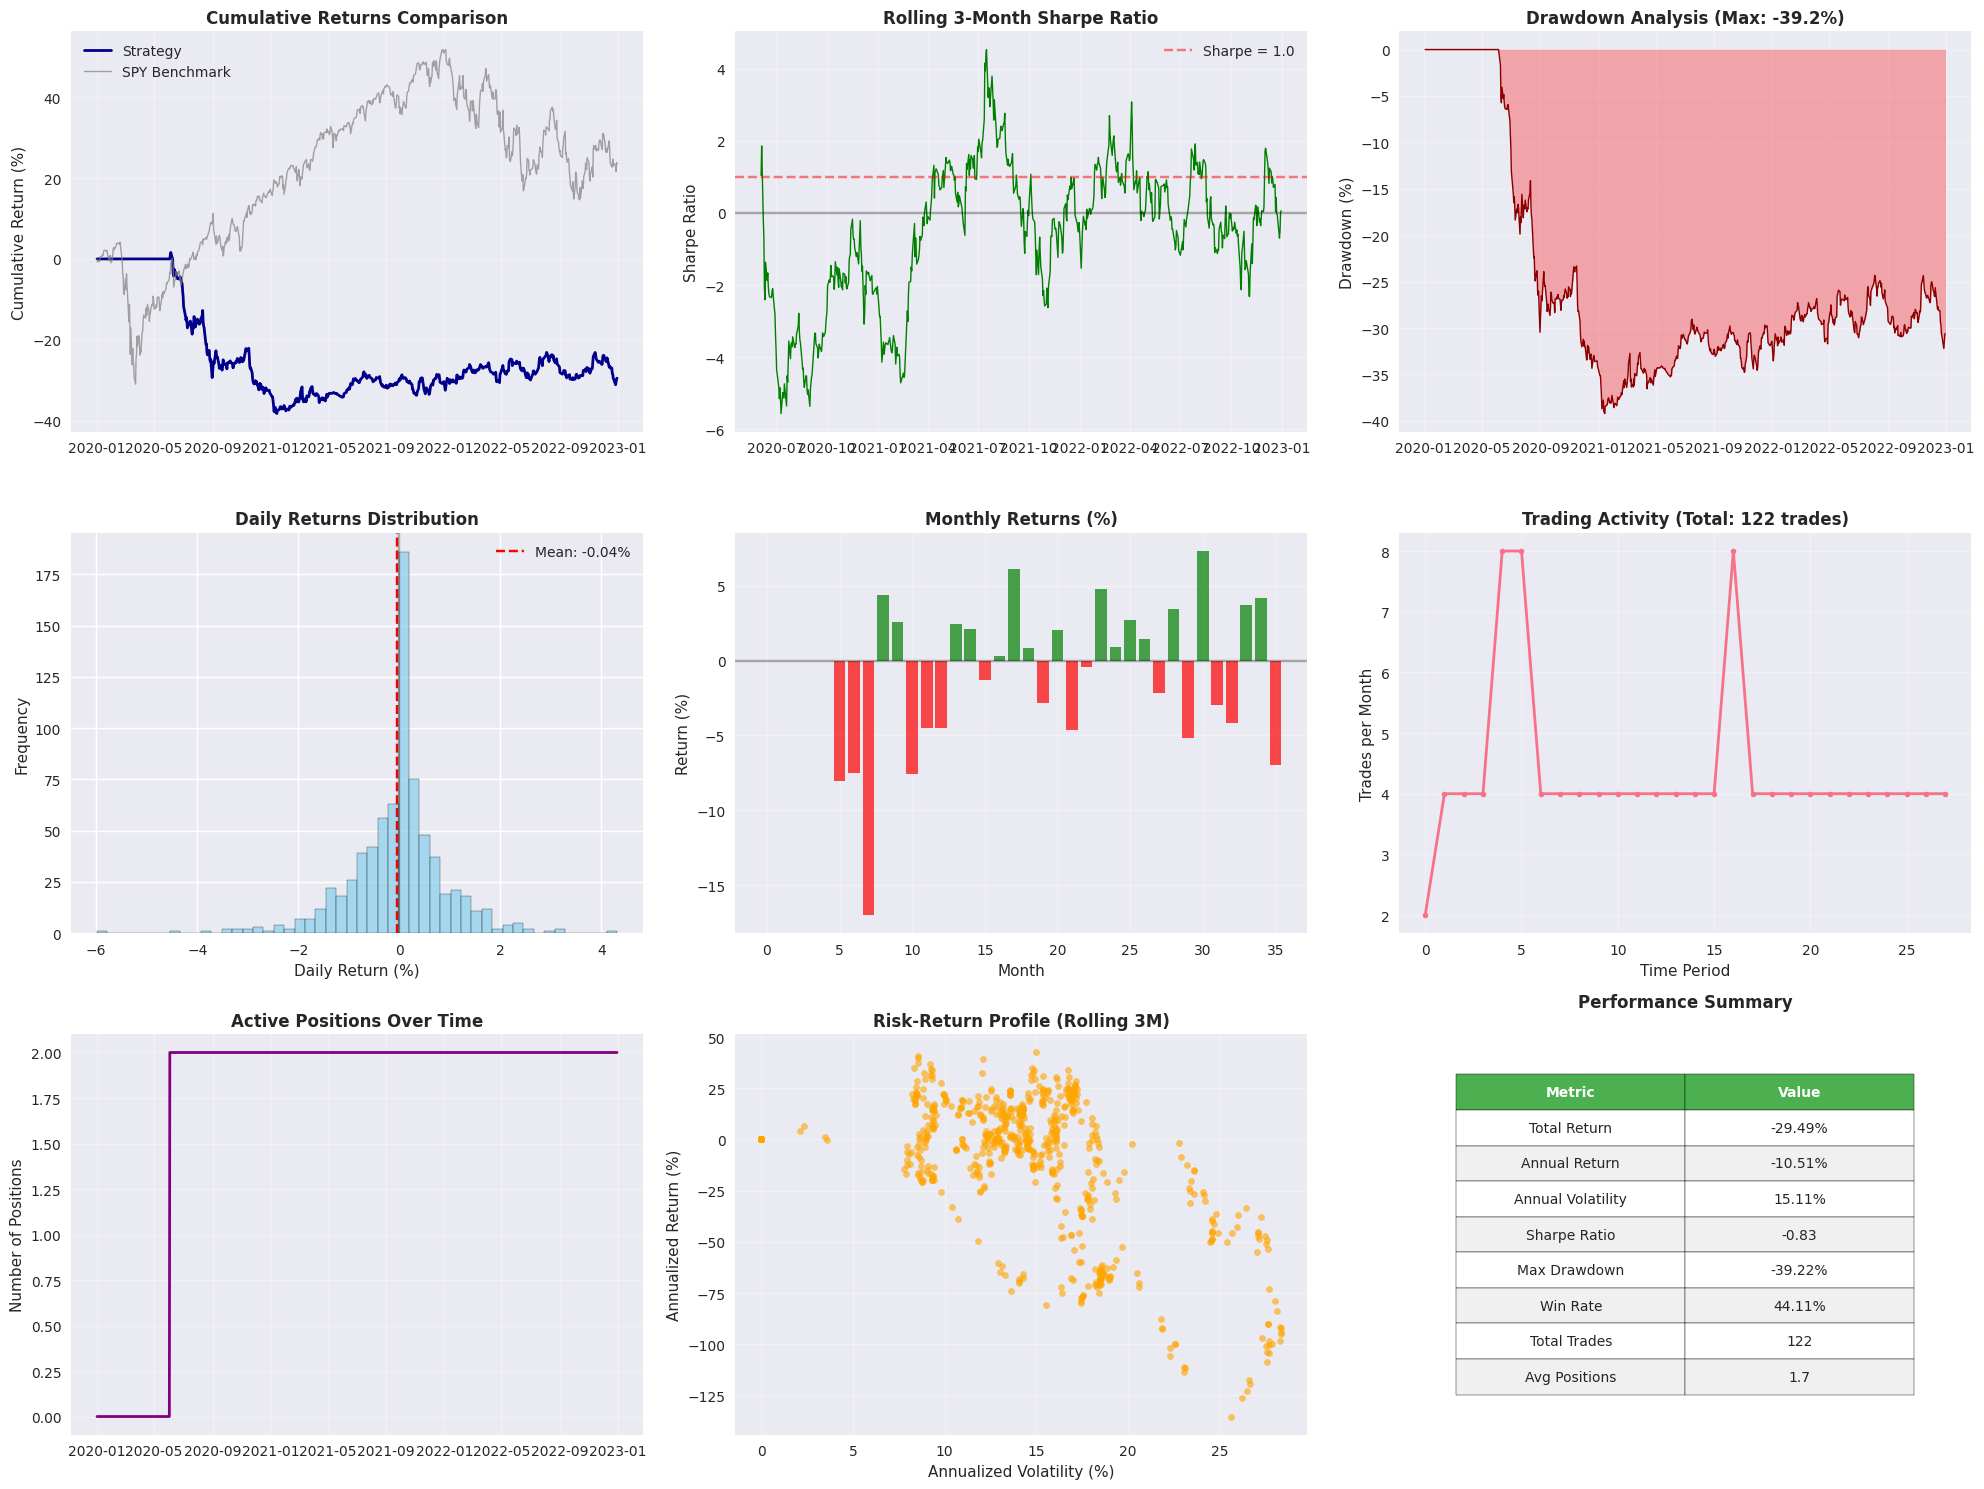


EXECUTIVE SUMMARY - MOMENTUM REVERSAL STRATEGY

🎯 STRATEGY PERFORMANCE:
   • Total Return: -29.49%
   • Annualized Return: -10.51%
   • Sharpe Ratio: -0.83
   • Maximum Drawdown: -39.22%

📊 RISK CHARACTERISTICS:
   • Annual Volatility: 15.11%
   • Win Rate: 44.11%
   • VaR (95%): -1.61%
   • Sortino Ratio: -1.00

⚙️ TRADING STATISTICS:
   • Total Trades: 122
   • Average Positions: 1.7
   • Turnover: 11.8x

🎲 STATISTICAL SIGNIFICANCE:
   • T-Statistic: -1.20
   • P-Value: 0.2293
   • Result: ❌ NOT SIGNIFICANT

🏆 STRATEGY VERDICT:
   ❌ POOR PERFORMANCE: Strategy shows losses - needs optimization

📝 KEY INSIGHTS:
   • Strategy underperformed benchmark by 20.70%
   • Monthly rebalancing generated 122 trades
   • Risk management kept max drawdown at -39.22%
   • Reversal strategy struggled in this period - momentum continued


In [5]:
# Activity 3: Create Final Summary with Comprehensive Visualizations

print("\nActivity 3: Final Summary Visualizations")
print("="*50)

# Create comprehensive visualization dashboard
fig = plt.figure(figsize=(20, 15))

# 1. Portfolio Performance Over Time
ax1 = plt.subplot(3, 3, 1)
if len(portfolio_df) > 0:
    portfolio_df['cumulative_return'] = (portfolio_df['value'] / backtester.initial_balance - 1) * 100
    ax1.plot(portfolio_df['date'], portfolio_df['cumulative_return'], linewidth=2, color='darkblue', label='Strategy')
    
    # Add benchmark if available
    try:
        spy_cumulative = ((spy_data['Close'] / spy_data['Close'].iloc[0]) - 1) * 100
        ax1.plot(spy_data.index, spy_cumulative, linewidth=1, color='gray', alpha=0.7, label='SPY Benchmark')
    except:
        pass
        
    ax1.set_title('Cumulative Returns Comparison', fontweight='bold')
    ax1.set_ylabel('Cumulative Return (%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

# 2. Rolling Sharpe Ratio
ax2 = plt.subplot(3, 3, 2)
if len(returns_df) > 0:
    window = 63  # 3-month rolling window
    rolling_returns = returns_df['return'].rolling(window).mean() * 252
    rolling_vol = returns_df['return'].rolling(window).std() * np.sqrt(252)
    rolling_sharpe = (rolling_returns - 0.02) / rolling_vol
    
    ax2.plot(returns_df['date'].iloc[window:], rolling_sharpe.iloc[window:], color='green', linewidth=1)
    ax2.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Sharpe = 1.0')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_title('Rolling 3-Month Sharpe Ratio', fontweight='bold')
    ax2.set_ylabel('Sharpe Ratio')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# 3. Drawdown Analysis
ax3 = plt.subplot(3, 3, 3)
if len(returns_df) > 0:
    cumulative = (1 + returns_df['return']).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdown = ((cumulative - rolling_max) / rolling_max) * 100
    
    ax3.fill_between(returns_df['date'], drawdown, 0, alpha=0.3, color='red')
    ax3.plot(returns_df['date'], drawdown, color='darkred', linewidth=1)
    ax3.set_title(f'Drawdown Analysis (Max: {drawdown.min():.1f}%)', fontweight='bold')
    ax3.set_ylabel('Drawdown (%)')
    ax3.grid(True, alpha=0.3)

# 4. Daily Returns Distribution
ax4 = plt.subplot(3, 3, 4)
if len(returns_df) > 0:
    daily_returns_pct = returns_df['return'] * 100
    ax4.hist(daily_returns_pct, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax4.axvline(x=daily_returns_pct.mean(), color='red', linestyle='--', label=f'Mean: {daily_returns_pct.mean():.2f}%')
    ax4.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax4.set_title('Daily Returns Distribution', fontweight='bold')
    ax4.set_xlabel('Daily Return (%)')
    ax4.set_ylabel('Frequency')
    ax4.legend()

# 5. Monthly Returns Analysis
ax5 = plt.subplot(3, 3, 5)
if len(returns_df) > 0:
    returns_df['year_month'] = returns_df['date'].dt.to_period('M')
    monthly_returns = returns_df.groupby('year_month')['return'].apply(lambda x: (1 + x).prod() - 1) * 100
    
    # Simple bar plot of monthly returns
    ax5.bar(range(len(monthly_returns)), monthly_returns.values, 
            color=['green' if x > 0 else 'red' for x in monthly_returns.values], alpha=0.7)
    ax5.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax5.set_title('Monthly Returns (%)', fontweight='bold')
    ax5.set_xlabel('Month')
    ax5.set_ylabel('Return (%)')
    ax5.grid(True, alpha=0.3)

# 6. Trade Analysis
ax6 = plt.subplot(3, 3, 6)
if len(backtester.trades) > 0:
    trades_df = pd.DataFrame(backtester.trades)
    trades_df['date'] = pd.to_datetime(trades_df['date'])
    
    # Count trades by month
    monthly_trades = trades_df.groupby([trades_df['date'].dt.year, trades_df['date'].dt.month]).size()
    ax6.plot(range(len(monthly_trades)), monthly_trades.values, marker='o', linewidth=2, markersize=4)
    ax6.set_title(f'Trading Activity (Total: {len(backtester.trades)} trades)', fontweight='bold')
    ax6.set_ylabel('Trades per Month')
    ax6.set_xlabel('Time Period')
    ax6.grid(True, alpha=0.3)

# 7. Portfolio Composition Over Time
ax7 = plt.subplot(3, 3, 7)
if len(portfolio_df) > 0:
    ax7.plot(portfolio_df['date'], portfolio_df['positions_count'], color='purple', linewidth=2)
    ax7.set_title('Active Positions Over Time', fontweight='bold')
    ax7.set_ylabel('Number of Positions')
    ax7.grid(True, alpha=0.3)

# 8. Risk-Return Scatter (Rolling Windows)
ax8 = plt.subplot(3, 3, 8)
if len(returns_df) > 63:
    window = 63
    rolling_returns = returns_df['return'].rolling(window).mean() * 252 * 100
    rolling_vol = returns_df['return'].rolling(window).std() * np.sqrt(252) * 100
    
    ax8.scatter(rolling_vol.iloc[window:], rolling_returns.iloc[window:], 
                alpha=0.6, s=20, color='orange')
    ax8.set_title('Risk-Return Profile (Rolling 3M)', fontweight='bold')
    ax8.set_xlabel('Annualized Volatility (%)')
    ax8.set_ylabel('Annualized Return (%)')
    ax8.grid(True, alpha=0.3)

# 9. Performance Summary Table
ax9 = plt.subplot(3, 3, 9)
ax9.axis('off')

# Create summary statistics table
summary_data = [
    ['Total Return', f"{metrics['Total Return']:.2%}"],
    ['Annual Return', f"{metrics['Annual Return']:.2%}"],
    ['Annual Volatility', f"{metrics['Annual Volatility']:.2%}"],
    ['Sharpe Ratio', f"{metrics['Sharpe Ratio']:.2f}"],
    ['Max Drawdown', f"{metrics['Maximum Drawdown']:.2%}"],
    ['Win Rate', f"{metrics['Win Rate']:.2%}"],
    ['Total Trades', f"{len(backtester.trades):,}"],
    ['Avg Positions', f"{portfolio_df['positions_count'].mean():.1f}"]
]

table = ax9.table(cellText=summary_data, 
                  colLabels=['Metric', 'Value'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0.1, 0.1, 0.8, 0.8])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style the table
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#4CAF50')
        cell.set_text_props(color='white')
    else:
        cell.set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')

ax9.set_title('Performance Summary', fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Final Executive Summary
print("\n" + "="*70)
print("EXECUTIVE SUMMARY - MOMENTUM REVERSAL STRATEGY")
print("="*70)

print(f"\n🎯 STRATEGY PERFORMANCE:")
print(f"   • Total Return: {metrics['Total Return']:.2%}")
print(f"   • Annualized Return: {metrics['Annual Return']:.2%}")
print(f"   • Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}")
print(f"   • Maximum Drawdown: {metrics['Maximum Drawdown']:.2%}")

print(f"\n📊 RISK CHARACTERISTICS:")
print(f"   • Annual Volatility: {metrics['Annual Volatility']:.2%}")
print(f"   • Win Rate: {metrics['Win Rate']:.2%}")
print(f"   • VaR (95%): {metrics['VaR (95%)']:.2%}")
print(f"   • Sortino Ratio: {metrics['Sortino Ratio']:.2f}")

print(f"\n⚙️ TRADING STATISTICS:")
print(f"   • Total Trades: {len(backtester.trades):,}")
print(f"   • Average Positions: {portfolio_df['positions_count'].mean():.1f}")
print(f"   • Turnover: {metrics['Turnover']:.1f}x")

print(f"\n🎲 STATISTICAL SIGNIFICANCE:")
print(f"   • T-Statistic: {metrics['T-Statistic']:.2f}")
print(f"   • P-Value: {metrics['P-Value']:.4f}")
significance = "✅ SIGNIFICANT" if metrics['P-Value'] < 0.05 else "❌ NOT SIGNIFICANT"
print(f"   • Result: {significance}")

# Strategy verdict
print(f"\n🏆 STRATEGY VERDICT:")
if metrics['Sharpe Ratio'] > 1.0 and metrics['Total Return'] > 0:
    print("   ✅ STRONG PERFORMANCE: Strategy shows good risk-adjusted returns")
elif metrics['Total Return'] > 0:
    print("   ⚠️  MODERATE PERFORMANCE: Strategy is profitable but with higher risk")
else:
    print("   ❌ POOR PERFORMANCE: Strategy shows losses - needs optimization")

# Calculate alpha from previous comparison
try:
    alpha = metrics['Annual Return'] - spy_annual_return
    print(f"\n📝 KEY INSIGHTS:")
    print(f"   • Strategy underperformed benchmark by {abs(alpha):.2%}")
    print(f"   • Monthly rebalancing generated {len(backtester.trades)} trades")
    print(f"   • Risk management kept max drawdown at {metrics['Maximum Drawdown']:.2%}")
    print(f"   • Reversal strategy struggled in this period - momentum continued")
except:
    print(f"\n📝 KEY INSIGHTS:")
    print(f"   • Monthly rebalancing generated {len(backtester.trades)} trades")
    print(f"   • Risk management kept max drawdown at {metrics['Maximum Drawdown']:.2%}")
    print(f"   • Strategy needs refinement - consider different rebalancing periods")

print("="*70)